In [ ]:
# Install required libraries
!pip install -q kaggle pandas numpy scikit-image scikit-learn tensorflow matplotlib ipywidgets
!pip instal kaggle

In [ ]:
# Connect kaggle for dataset
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle

In [ ]:
# Download and unzip the Indian Traffic Sign Dataset
!kaggle datasets download -d sarangdilipjodh/indian-traffic-signs-prediction85-classes
!unzip indian-traffic-signs-prediction85-classes.zip -d /content/indian-traffic-sign-dataset

In [ ]:
# Model
!kaggle datasets download -d madmaxliu/inceptionv3
!unzip inceptionv3.zip -d /content/inceptionv3

In [3]:
# Importing Libraries
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Base Path for all files
data_dir = '/content/indian-traffic-sign-dataset/traffic_sign_classification_dataset/train'

In [5]:
# Using ImageDataGenerator to load the Images for Training and Testing the CNN Model
datagenerator = {
    "train": ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rescale=1. / 255,validation_split=0.1,shear_range=0.1,zoom_range=0.1,width_shift_range=0.1,
                                height_shift_range=0.1,
                                rotation_range=30,
                               ).flow_from_directory(directory=data_dir,target_size=(300, 300),subset='training',),

    "valid": ImageDataGenerator(rescale=1 / 255,
                                validation_split=0.1,
                               ).flow_from_directory(directory=data_dir,
                                                     target_size=(300, 300),
                                                     subset='validation',
                                                    ),
}

Found 4031 images belonging to 85 classes.
Found 407 images belonging to 85 classes.


In [10]:
# Initializing InceptionV3 (pretrained) model with input image shape as (300, 300, 3)
base_model = InceptionV3(weights=None, include_top=False, input_shape=(300, 300, 3))

# Load Weights for the InceptionV3 Model
base_model.load_weights('/content/inceptionv3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

# Setting the Training of all layers of InceptionV3 model to false
base_model.trainable = False

In [11]:
# Adding some more layers at the end of the Model as per our requirement
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.15),
    Dense(1024, activation='relu'),
    Dense(85, activation='softmax') # 85 Output Neurons for 85 Classes
])

In [12]:
# Using the Adam Optimizer to set the learning rate of our final model
opt = optimizers.Adam(learning_rate=0.0001)

# Compiling and setting the parameters we want our model to use
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

In [13]:
# Viewing the summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 85)             │        87,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,988,085 (91.51 MB)

 Trainable params: 2,185,301 (8.34 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [34]:
# Setting variables for the model
batch_size = 32
epochs = 16

# Seperating Training and Testing Data
train_generator = datagenerator["train"]
valid_generator = datagenerator["valid"]

In [35]:
# Calculating variables for the model
steps_per_epoch = train_generator.n // batch_size
validation_steps = valid_generator.n // batch_size

print("steps_per_epoch :", steps_per_epoch)
print("validation_steps :", validation_steps)

steps_per_epoch : 125
validation_steps : 12


In [ ]:
# # File Path to store the trained models
# filepath = ""

# # Using the ModelCheckpoint function to train and store all the best models
# checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# callbacks_list = [checkpoint1]
# # Training the Model
# history = model.fit_generator(generator=train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch,
#                               validation_data=valid_generator, validation_steps=validation_steps,
#                               callbacks=callbacks_list)\
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define folder and filename
save_dir = "content"
filename = "best_model.keras"
filepath = os.path.join(save_dir, filename)

# ✅ Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Setup ModelCheckpoint callback
checkpoint1 = ModelCheckpoint(
    filepath,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

callbacks_list = [checkpoint1]

# ✅ Training the model
history = model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps,
    callbacks=callbacks_list
)


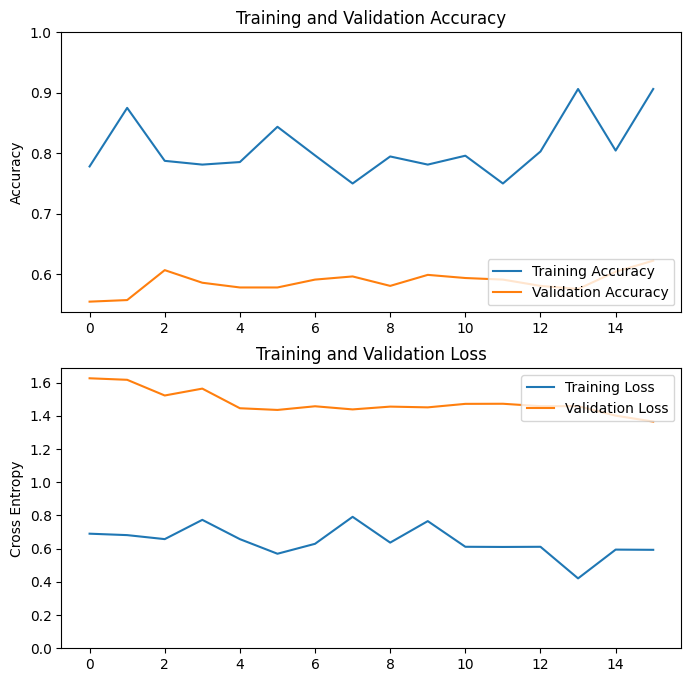

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# ________________ Graph 1 -------------------------

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# ________________ Graph 2 -------------------------

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [38]:
# Calculate the Loss and Accuracy on the Validation Data
test_loss, test_acc = model.evaluate(valid_generator)
print('test accuracy : ', test_acc)

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 270ms/step - accuracy: 0.6721 - loss: 1.2641
test accuracy :  0.6191646456718445


In [39]:
from tensorflow.keras.models import load_model
import pickle

# 1. Save the model in native format
model.save("best_model.keras")  # This saves weights, config, optimizer state

# 2. (Optional) Save class indices mapping using pickle
class_indices = train_generator.class_indices

with open("class_indices.pkl", "wb") as f:
    pickle.dump(class_indices, f)

print("Model saved as best_model.keras")
print("Class indices saved as class_indices.pkl")


Model saved as best_model.keras
Class indices saved as class_indices.pkl
